In [1]:
import pandas as pd

In [2]:
base = "../data"

In [3]:
df = pd.read_csv(f"{base}/train_preprocessed.csv")
df.sample(3)

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity
32891,are you kidding me you know what i won t even...,57842339d5629d49,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0
66115,merging makes sense to me there s nothing in ...,b0c9807e597d54b1,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
53036,when you add sourced facts and they are delete...,8dbcf338d67ac104,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0


In [4]:
df.shape

(159571, 10)

In [5]:
df_ = pd.read_csv(f"{base}/test_preprocessed.csv")
df = pd.concat([df, df_])
df.shape

(312735, 10)

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 0, 'class')

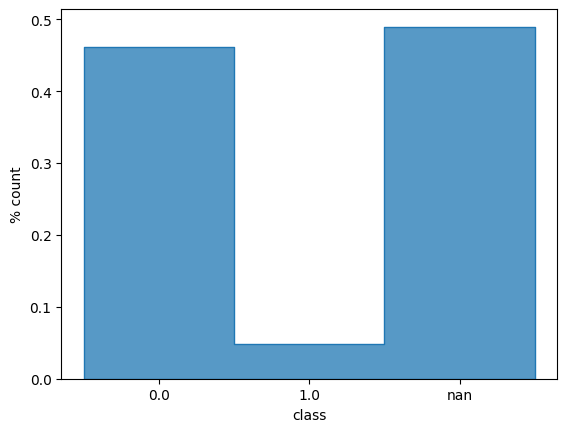

In [7]:
df_copy = df.copy()
df_copy['toxic'] = df_copy['toxic'].astype('str')

sns.histplot(
    data=df_copy,
    x='toxic',
    element="step",
    stat='density',
    common_norm=False
)

plt.ylabel('% count')
plt.xlabel('class')

In [8]:
df2 = pd.read_csv(f"{base}/youtoxic_english_1000.csv")
df2.sample(3)

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
339,UghCYfz3QB2s-ngCoAEC,9pr1oE34bIM,"LOL, trayvon's online name was ""nolimitnigga""....",True,True,False,True,False,True,True,False,False,False,False,False
329,Ugh4W1Xv2z1RHHgCoAEC,9pr1oE34bIM,"Remember,the looting(stealing) by the blacks i...",True,False,False,False,False,True,True,False,False,False,False,False
30,UggYHsvinXkgM3gCoAEC,04kJtp6pVXI,"stop being criminals and you wont get shot, th...",True,True,False,True,False,False,False,False,False,False,False,False


Text(0.5, 0, 'class')

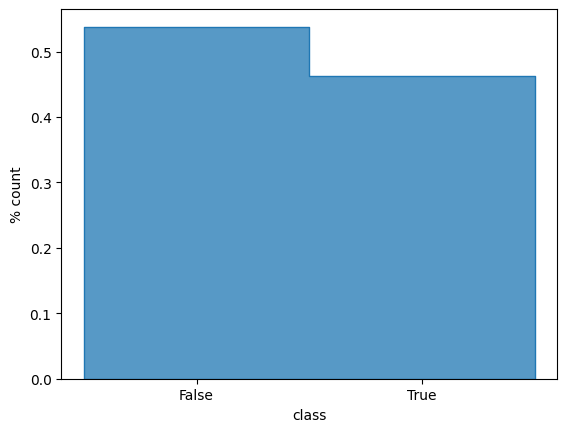

In [9]:
df2_copy = df2.copy()
df2_copy['IsToxic'] = df2_copy['IsToxic'].astype('str')

sns.histplot(
    data=df2_copy,
    x='IsToxic',
    element="step",
    stat='density',
    common_norm=False
)

plt.ylabel('% count')
plt.xlabel('class')

Будем заниматься бинарной классификацией для предсказанания целевой переменной isToxic. В качестве метрики используем *f1-score*

Проведём лемматизацию данных

In [10]:
import sys, os.path
utils = (os.path.abspath(os.path.join(os.path.dirname(''), '..'))
+ '/utils')
sys.path.append(utils) # to make all utils files importable

In [11]:
from text_refactorer import refactor_data

In [12]:
df[df['comment_text'].isna()]

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity
506,NaN,00d2aca8d65aa590,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
10573,NaN,11b30d2a67102880,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
10988,NaN,1272c25ed799c527,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
28247,NaN,2efe67facf334be4,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
45000,NaN,4aa56610aade012e,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
55331,NaN,5c08635f8401e98e,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
74006,NaN,7b4951508a68fc00,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
82830,NaN,8a21d8383a4b41b8,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
104010,NaN,ad968d3ec5bac5c2,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
110976,NaN,b92178ef605b594a,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN


In [13]:
df.dropna(subset=['comment_text', 'toxic'], inplace=True)

In [14]:
df_lemmatized = df.copy()
df_lemmatized['text'] = refactor_data(df_lemmatized['comment_text'])
df_lemmatized.sample(3)

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity,text
54809,u s department of state the u s department ...,927b980135140be1,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0,u department state u department state say roma...
94172,october utc actually i endorsed what you pr...,fbd28a46ddf4397e,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0,october utc actually endorse propose civility ...
144821,welcome hello and welcome to wikipedia thank ...,12f4422cf36ed980,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0,welcome hello welcome wikipedia thank contribu...


In [15]:
df_lemmatized.toxic.value_counts()

toxic
0.0    144277
1.0     15294
Name: count, dtype: int64

In [16]:
df2_lemmatized = df2.copy()
df2_lemmatized['text'] = refactor_data(df2_lemmatized['Text'])
df2_lemmatized.sample(3)

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism,text
273,UggFEwIh2dDAhXgCoAEC,9pr1oE34bIM,"@Stefan Molyneux You sir, are the dumbest smar...",True,True,False,False,False,False,False,False,False,False,False,False,stefan molyneux sir dumb smart guy ever resear...
719,Ugj-DZyJ6rJBOXgCoAEC,dDbRyFIkNII,Who the hell cares if there are people peacef...,True,True,False,True,True,False,False,False,False,False,False,False,hell care people peacefully protest police fee...
817,UgjDETjpfRQL6HgCoAEC,dG7mZQvaQDk,I love her. Every thug deserves a slug,True,False,False,False,False,True,True,False,False,False,False,False,love every thug deserve slug


In [17]:
df2_lemmatized['toxic'] = df2_lemmatized['IsToxic']

In [18]:
df2_lemmatized['toxic'].isna().sum()

0

In [19]:
cols = ['toxic', 'text']
df_prepared = pd.concat([df_lemmatized[cols], df2_lemmatized[cols]])

In [20]:
df_prepared.text.isna().sum()

0

In [21]:
prep = f"{base}/prepared.csv"
df_prepared.to_csv(prep, index=False)